In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline

PRODUCTOS_CSV = "../data/productos.csv"
CLIENTES_CSV = "../data/clientes.csv"
HISTORIAL_COMPRAS = "../data/historial_compras.csv"
COMENTARIOS_CSV = "../data/comentarios.csv"

productos = pd.read_csv(PRODUCTOS_CSV)
clientes = pd.read_csv(CLIENTES_CSV)
historial_compras = pd.read_csv(HISTORIAL_COMPRAS)
comentarios_df = pd.read_csv(COMENTARIOS_CSV)

/Users/erichuiza/Documents/pucp/miería web/dev/sesion-de-clase-06/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use mps:0


In [5]:
def analizar_sentimiento(text):
    if pd.isna(text) or text == "":
        return {"label": "3 stars", "score": 0.5} # Neutro si el comentario está vacío
    try:
        # El modelo de nlptown retorna una lista de 1 elemento
        return sentiment_pipeline(str(text))[0]
    except Exception as e:
        # Fallback si el texto es muy largo o inválido
        return {"label": "3 stars", "score": 0.5}

resultados = comentarios_df["texto_comentario"].apply(analizar_sentimiento)

In [7]:
# Mapear los resultados
comentarios_df.loc[resultados.index, "sentimiento"] = resultados.apply(lambda r: r["label"])
comentarios_df.loc[resultados.index, "score"] = resultados.apply(lambda r: r["score"])

comentarios_df.head()

,id_comentario,id_cliente,id_producto,calificacion,texto_comentario,fecha_comentario,sentimiento,score
0,1,1,2,5,El Smartphone Nexus 5G es un cambio de juego. ...,2024-05-20,5 stars,0.695212
1,2,2,4,4,La Camiseta Deportiva Ultralight es muy cómoda...,2024-05-21,4 stars,0.596878
2,3,3,1,5,La Laptop Gamer Pro es una bestia de rendimien...,2024-05-22,5 stars,0.814063
3,4,4,5,3,Las Zapatillas Urbanas Fit tienen un diseño mu...,2024-05-23,3 stars,0.505103
4,5,5,3,4,Los Auriculares Inalámbricos X ofrecen un soni...,2024-05-24,4 stars,0.850220


In [8]:
# Polaridad de Sentimiento
sentiment_map = {'5 stars': 1.0, '4 stars': 0.5, '3 stars': 0.0, '2 stars': -0.5, '1 star': -1.0}
comentarios_df["polaridad"] = comentarios_df["sentimiento"].map(sentiment_map)
comentarios_df.head()

,id_comentario,id_cliente,id_producto,calificacion,texto_comentario,fecha_comentario,sentimiento,score,polaridad
0,1,1,2,5,El Smartphone Nexus 5G es un cambio de juego. ...,2024-05-20,5 stars,0.695212,1.0
1,2,2,4,4,La Camiseta Deportiva Ultralight es muy cómoda...,2024-05-21,4 stars,0.596878,0.5
2,3,3,1,5,La Laptop Gamer Pro es una bestia de rendimien...,2024-05-22,5 stars,0.814063,1.0
3,4,4,5,3,Las Zapatillas Urbanas Fit tienen un diseño mu...,2024-05-23,3 stars,0.505103,0.0
4,5,5,3,4,Los Auriculares Inalámbricos X ofrecen un soni...,2024-05-24,4 stars,0.850220,0.5


In [9]:
# Sentimiento promedio por cliente
sentimiento_por_cliente = comentarios_df.groupby("id_cliente")["polaridad"].mean().reset_index(name="sentimiento_promedio")
sentimiento_por_cliente.head()

,id_cliente,sentimiento_promedio
0,1,0.777778
1,2,0.555556
2,3,0.388889
3,4,0.611111
4,5,0.611111


In [12]:
compras_prod = historial_compras.merge(productos, on="id_producto", how="left")
compras_prod["precio_compra"] = compras_prod["cantidad"] * compras_prod["precio"]

valor_por_cliente = compras_prod.groupby("id_cliente")["precio_compra"].sum().reset_index(name="valor_total_compra")
valor_por_cliente.head()

,id_cliente,valor_total_compra
0,1,12444.20
1,2,1123.74
2,3,2735.22
3,4,3790.74
4,5,4172.49


In [14]:
matriz_riesgo = clientes.merge(valor_por_cliente, on="id_cliente", how="left").fillna(0)
matriz_riesgo = matriz_riesgo.merge(sentimiento_por_cliente, on="id_cliente", how="left").fillna(0)
matriz_riesgo["sentimiento_promedio"] = matriz_riesgo["sentimiento_promedio"].fillna(0)
matriz_riesgo.head()

,id_cliente,nombre,email,ciudad,pais,fecha_registro,valor_total_compra,sentimiento_promedio
0,1,Ana Martínez,ana.m@email.com,Madrid,España,2024-05-10,12444.20,0.777778
1,2,Carlos Sánchez,carlos.s@email.com,Ciudad de México,México,2024-05-11,1123.74,0.555556
2,3,María López,maria.l@email.com,Bogotá,Colombia,2024-05-12,2735.22,0.388889
3,4,Jorge García,jorge.g@email.com,Buenos Aires,Argentina,2024-05-13,3790.74,0.611111
4,5,Valentina Pérez,valentina.p@email.com,Santiago,Chile,2024-05-14,4172.49,0.611111


In [33]:
# Define umbrales dinámicos
valor_medio = matriz_riesgo["valor_total_compra"].median()
sentimiento_negativo = 0.4 # Umbral para considerar "negativo" de forma clara

def clasificar_segmento(row):
    alto_valor = row["valor_total_compra"] > valor_medio
    negativo = row["sentimiento_promedio"] < sentimiento_negativo

    if negativo and alto_valor:
        return "Alto Riesgo (VIP Infeliz)" # SIN EMOJI
    elif not negativo and alto_valor:
        return "Promotores de Alto Valor" # SIN EMOJI
    elif negativo and not alto_valor:
        return "Clientes Ruidosos (Bajo Valor)" # SIN EMOJI
    else:
        return "Clientes Satisfechos" # SIN EMOJI

matriz_riesgo["segmento_crm"] = matriz_riesgo.apply(clasificar_segmento, axis=1)
matriz_riesgo.head()

,id_cliente,nombre,email,ciudad,pais,fecha_registro,valor_total_compra,sentimiento_promedio,segmento_crm
0,1,Ana Martínez,ana.m@email.com,Madrid,España,2024-05-10,12444.20,0.777778,Promotores de Alto Valor
1,2,Carlos Sánchez,carlos.s@email.com,Ciudad de México,México,2024-05-11,1123.74,0.555556,Clientes Satisfechos
2,3,María López,maria.l@email.com,Bogotá,Colombia,2024-05-12,2735.22,0.388889,Clientes Ruidosos (Bajo Valor)
3,4,Jorge García,jorge.g@email.com,Buenos Aires,Argentina,2024-05-13,3790.74,0.611111,Promotores de Alto Valor
4,5,Valentina Pérez,valentina.p@email.com,Santiago,Chile,2024-05-14,4172.49,0.611111,Promotores de Alto Valor


In [35]:
print("\n" + "="*50)
print("             RESULTADOS DE SEGMENTACIÓN DE RIESGO")
print("="*50)

# Resumen de Segmentos
resumen = matriz_riesgo.groupby("segmento_crm").agg(
    Conteo=('id_cliente', 'size'),
    Valor_Promedio=('valor_total_compra', 'mean')
).reset_index().sort_values(by="Conteo", ascending=False)

resumen["Valor_Promedio"] = resumen["Valor_Promedio"].map('${:,.2f}'.format)

print("\nResumen de Segmentos:")
print(resumen.to_markdown(index=False))

# Segmento de MÁXIMO RIESGO (Alto Valor, Sentimiento Negativo)
segmento_vip_infeliz = "Alto Riesgo (VIP Infeliz)" # SIN EMOJI
riesgo_vip_df = matriz_riesgo[matriz_riesgo["segmento_crm"] == segmento_vip_infeliz] \
    .sort_values(by=["valor_total_compra", "sentimiento_promedio"], ascending=[False, True]) \
    .head(5)

print(f"\nTop 5 Clientes en {segmento_vip_infeliz} (Máxima Prioridad):")
if not riesgo_vip_df.empty:
    print(riesgo_vip_df[["nombre", "valor_total_compra", "sentimiento_promedio"]].to_markdown(index=False))
else:
    print("No hay clientes en este segmento.")


# Segmento de RIESGO SECUNDARIO (Bajo Valor, Sentimiento Negativo)
segmento_ruidoso = "Clientes Ruidosos (Bajo Valor)" # SIN EMOJI
riesgo_ruidoso_df = matriz_riesgo[matriz_riesgo["segmento_crm"] == segmento_ruidoso] \
    .sort_values(by=["sentimiento_promedio", "valor_total_compra"], ascending=[True, False]) \
    .head(5)

print(f"\nTop 5 Clientes en {segmento_ruidoso} (Recolección de Feedback):")
if not riesgo_ruidoso_df.empty:
    print(riesgo_ruidoso_df[["nombre", "valor_total_compra", "sentimiento_promedio"]].to_markdown(index=False))
else:
    print("No hay clientes en este segmento.")


             RESULTADOS DE SEGMENTACIÓN DE RIESGO

Resumen de Segmentos:
| segmento_crm                   |   Conteo | Valor_Promedio   |
|:-------------------------------|---------:|:-----------------|
| Clientes Satisfechos           |       10 | $557.22          |
| Promotores de Alto Valor       |       10 | $6,841.55        |
| Clientes Ruidosos (Bajo Valor) |        3 | $1,856.40        |
| Alto Riesgo (VIP Infeliz)      |        2 | $8,607.34        |

Top 5 Clientes en Alto Riesgo (VIP Infeliz) (Máxima Prioridad):
| nombre        |   valor_total_compra |   sentimiento_promedio |
|:--------------|---------------------:|-----------------------:|
| Lucía Gómez   |             13444.7  |               0.37037  |
| Felipe Acosta |              3769.99 |               0.388889 |

Top 5 Clientes en Clientes Ruidosos (Bajo Valor) (Recolección de Feedback):
| nombre        |   valor_total_compra |   sentimiento_promedio |
|:--------------|---------------------:|-----------------------:

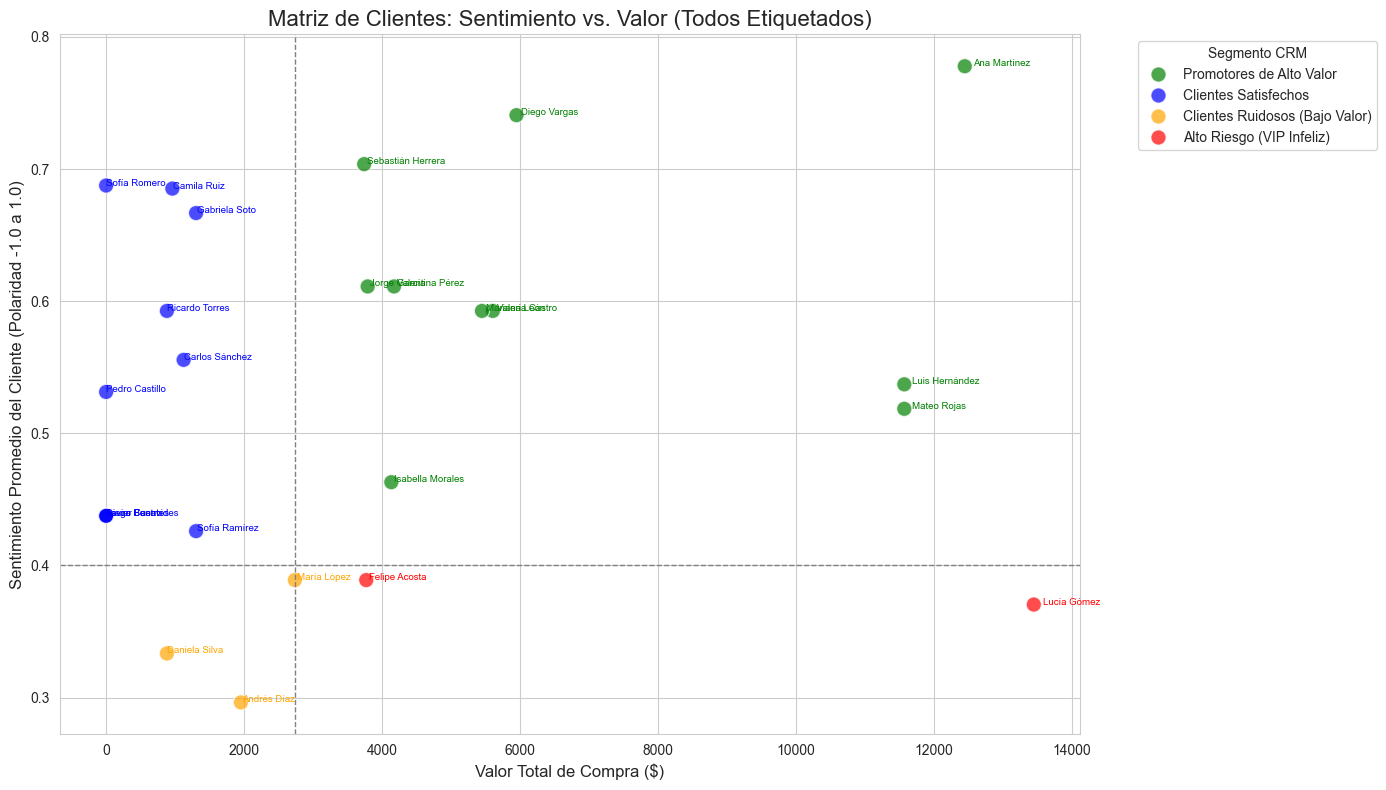

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

segmento_colores = {
    "Alto Riesgo (VIP Infeliz)": "red",
    "Clientes Ruidosos (Bajo Valor)": "orange",
    "Promotores de Alto Valor": "green",
    "Clientes Satisfechos": "blue"
}

sns.scatterplot(
    data=matriz_riesgo,
    x="valor_total_compra",
    y="sentimiento_promedio",
    hue="segmento_crm",
    palette=segmento_colores,
    s=120, # Tamaño de los puntos
    alpha=0.7,
    legend=True
)

for i, row in matriz_riesgo.iterrows():
    text_color = segmento_colores.get(row["segmento_crm"], 'black')

    plt.text(
        row["valor_total_compra"] * 1.01,
        row["sentimiento_promedio"],
        row["nombre"],
        horizontalalignment='left',
        size='x-small',
        color=text_color,
        weight='normal'
    )

plt.axvline(valor_medio, color='gray', linestyle='--', linewidth=1.0)
plt.axhline(sentimiento_negativo, color='gray', linestyle='--', linewidth=1.0)

# Títulos
plt.title('Matriz de Clientes: Sentimiento vs. Valor (Todos Etiquetados)', fontsize=16)
plt.xlabel('Valor Total de Compra ($)', fontsize=12)
plt.ylabel('Sentimiento Promedio del Cliente (Polaridad -1.0 a 1.0)', fontsize=12)

# Vuelve a añadir la leyenda automáticamente y la reposicionamos
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l, title='Segmento CRM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()